In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [3]:
from google.colab import files


uploaded = files.upload()

Saving zomato.csv to zomato.csv


#**Data Summary**

In [4]:
data = pd.read_csv("zomato.csv", encoding='latin-1')
data.columns = [c.replace(" ", "_") for c in data.columns]


In [70]:
#look at data
data.head()

,Restaurant_ID,Restaurant_Name,Country_Code,City,Address,Locality,Locality_Verbose,Longitude,Latitude,Cuisines,...,Currency,Has_Table_booking,Has_Online_delivery,Is_delivering_now,Switch_to_order_menu,Price_range,Aggregate_rating,Rating_color,Rating_text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",...,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",...,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.057508,14.584450,"Japanese, Korean",...,Botswana Pula(P),Yes,No,No,No,4,4.8,Dark Green,Excellent,229


In [ ]:
data.info()
#check whether objects are non-null - it appears we have information for almost all cuisines

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant_ID         9551 non-null   int64  
 1   Restaurant_Name       9551 non-null   object 
 2   Country_Code          9551 non-null   int64  
 3   City                  9551 non-null   object 
 4   Address               9551 non-null   object 
 5   Locality              9551 non-null   object 
 6   Locality_Verbose      9551 non-null   object 
 7   Longitude             9551 non-null   float64
 8   Latitude              9551 non-null   float64
 9   Cuisines              9542 non-null   object 
 10  Average_Cost_for_two  9551 non-null   int64  
 11  Currency              9551 non-null   object 
 12  Has_Table_booking     9551 non-null   object 
 13  Has_Online_delivery   9551 non-null   object 
 14  Is_delivering_now     9551 non-null   object 
 15  Switch_to_order_menu 

In [71]:
# Compute the distribution
rating_distribution = data["Rating_text"].value_counts().reset_index()

# Rename the columns in the table
rating_distribution.columns = ["Rating Text", "Frequency"]

# Display the table. We should remove the Not Rated tables
print(rating_distribution)

  Rating Text  Frequency
0     Average       3737
1   Not rated       2148
2        Good       2100
3   Very Good       1079
4   Excellent        301
5        Poor        186


In [72]:
# Compute the distribution
currency_distribution = data["Currency"].value_counts().reset_index()

# Rename the columns in the table
currency_distribution.columns = ["Currency", "Frequency"]

# Display the table. We should remove the Not Rated tables
print(currency_distribution)

                  Currency  Frequency
0       Indian Rupees(Rs.)       8652
1                Dollar($)        482
2               Pounds(£)         80
3       Brazilian Real(R$)         60
4       Emirati Diram(AED)         60
5                  Rand(R)         60
6            NewZealand($)         40
7         Turkish Lira(TL)         34
8         Botswana Pula(P)         22
9   Indonesian Rupiah(IDR)         21
10         Qatari Rial(QR)         20
11   Sri Lankan Rupee(LKR)         20


# **Data Cleansing**

In [5]:
data
exchange_rates = {
    'Botswana Pula(P)': 13.755,
    'Brazilian Real(R$)': 5.058,
    'Dollar($)': 1,
    'Emirati Diram(AED)': 3.673,
    'Indian Rupees(Rs.)': 82.71,
    'Indonesian Rupiah(IDR)': 14980,
    'NewZealand($)': 1.655,
    'Pounds(Œ£)': 0.805,
    'Qatari Rial(QR)': 3.647,
    'Rand(R)': 19.743,
    'Sri Lankan Rupee(LKR)': 292.19,
    'Turkish Lira(TL)': 20.394
}

# Convert the "Average Cost for two" column to USD
data['Average Cost for two (USD)'] = data['Average_Cost_for_two'] / data['Currency'].map(exchange_rates)
data['City'].unique()

array(['Makati City', 'Mandaluyong City', 'Pasay City', 'Pasig City',
       'Quezon City', 'San Juan City', 'Santa Rosa', 'Tagaytay City',
       'Taguig City', 'Brasí_lia', 'Rio de Janeiro', 'Sí£o Paulo',
       'Albany', 'Armidale', 'Athens', 'Augusta', 'Balingup',
       'Beechworth', 'Boise', 'Cedar Rapids/Iowa City', 'Chatham-Kent',
       'Clatskanie', 'Cochrane', 'Columbus', 'Consort', 'Dalton',
       'Davenport', 'Des Moines', 'Dicky Beach', 'Dubuque',
       'East Ballina', 'Fernley', 'Flaxton', 'Forrest', 'Gainesville',
       'Hepburn Springs', 'Huskisson', 'Inverloch', 'Lakes Entrance',
       'Lakeview', 'Lincoln', 'Lorn', 'Macedon', 'Macon', 'Mayfield',
       'Mc Millan', 'Middleton Beach', 'Miller', 'Monroe', 'Montville',
       'Ojo Caliente', 'Orlando', 'Palm Cove', 'Paynesville', 'Penola',
       'Pensacola', 'Phillip Island', 'Pocatello', 'Potrero', 'Princeton',
       'Rest of Hawaii', 'Savannah', 'Singapore', 'Sioux City',
       'Tampa Bay', 'Tanunda', 'Trentha

In [6]:
new_data = data[['Price_range','Aggregate_rating','Average Cost for two (USD)', 'Votes', 'Rating_text']]
# Extract the first cuisine from the list
new_data = new_data[new_data['Aggregate_rating'] != 0]
new_data.dropna(inplace=True)

In [7]:
data_cat = new_data[['Price_range', 'Rating_text']]
data_num = new_data[['Average Cost for two (USD)', 'Aggregate_rating', 'Votes']]
new_data.dropna(inplace=True)

# **Exploratory Data Analysis**

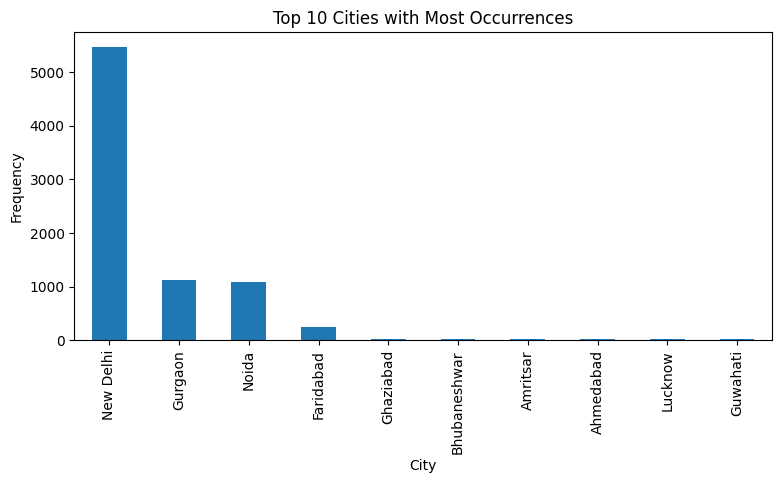

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 4))
data['City'].value_counts().head(10).plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Frequency')
plt.title('Top 10 Cities with Most Occurrences')
plt.show()

<ipython-input-13-f0b36712cf2b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, linewidths=2)


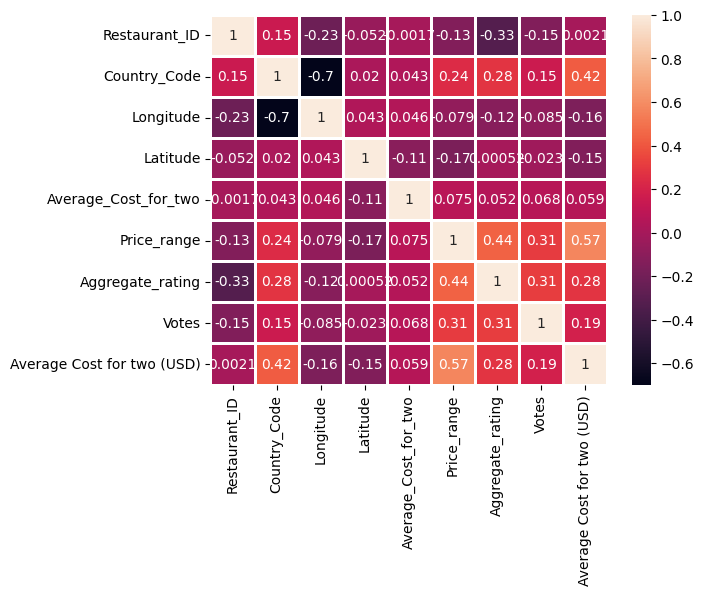

In [ ]:
#plot a heat map to shot initial correlations
sns.heatmap(data.corr(), annot=True, linewidths=2)
plt.show()

                            Average Cost for two (USD)  Aggregate_rating  \
Average Cost for two (USD)                    1.000000          0.310488   
Aggregate_rating                              0.310488          1.000000   
Votes                                         0.158840          0.412001   

                               Votes  
Average Cost for two (USD)  0.158840  
Aggregate_rating            0.412001  
Votes                       1.000000  


<Axes: >

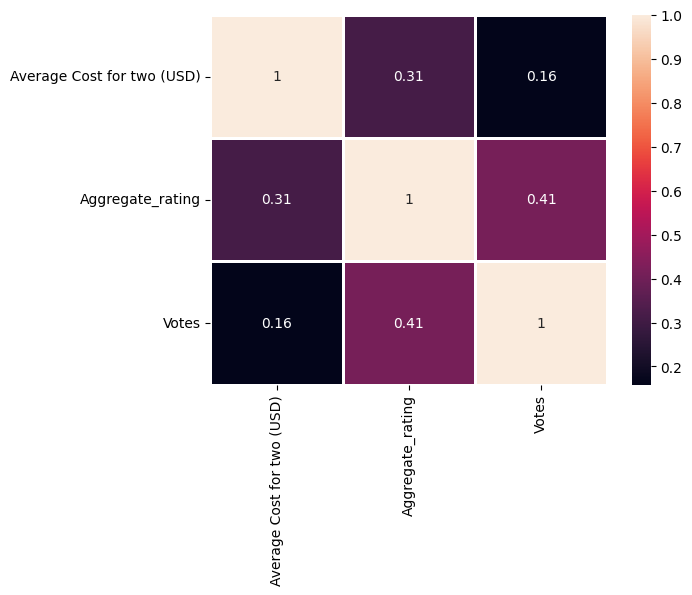

In [ ]:
#plot a heatmap to show later correlations
print(data_num.corr())
sns.heatmap(data_num.corr(),annot= True, linewidth=2)

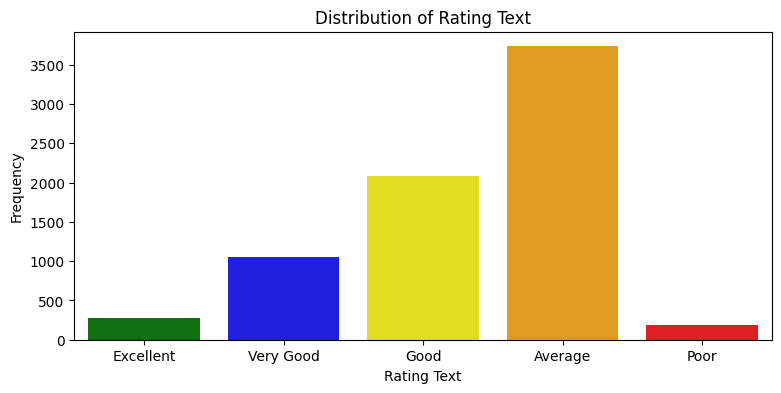

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom colors for each rating category
colors = ['green', 'blue', 'yellow', 'orange', 'red']

plt.figure(figsize=(9, 4))
sns.countplot(data=data_cat, x='Rating_text', palette=colors)
plt.xlabel('Rating Text')
plt.ylabel('Frequency')
plt.title('Distribution of Rating Text')
plt.show()

# **Data Analysis**

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV



y = new_data['Rating_text']
X = new_data[[ 'Price_range', 'Votes', 'Average Cost for two (USD)']]

from sklearn.model_selection import train_test_split
# Splitting the data into training and test sets with a 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Printing the shapes of the resulting datasets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (5126, 3)
Test set shape: (2198, 3)


**1 - Support Vector Classifier Model**

In [ ]:

modelSVC = SVC(kernel='poly', C=0.1, gamma=0.1, degree=2)
modelSVC = modelSVC.fit(X_train,y_train)
print("Training score", modelSVC.score(X_train,y_train))
print("Test score", modelSVC.score(X_test,y_test))



SVC Training score: 0.6184159188451034
SVC Test score: 0.6328480436760692
SVC Training time: 4051.5396575927734 seconds


**2 - Logistic Regression**

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import time

# Create an instance of Logistic Regression with desired parameters
logreg = LogisticRegression()

# Start measuring training time
start_time = time.time()

# Fit the logistic regression model on the training data
logreg.fit(X_train, y_train)

# Stop measuring training time and calculate elapsed time
end_time = time.time()
training_time = end_time - start_time

# Make predictions on the training and test data
train_predictions = logreg.predict(X_train)
test_predictions = logreg.predict(X_test)

# Calculate and print the accuracy scores
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)


print("Logistic Training Accuracy:", train_accuracy)
print("Logistic Test Accuracy:", test_accuracy)
print("Logistic Training Time:", training_time, "seconds")


Logistic Training Accuracy: 0.6256340226297308
Logistic Test Accuracy: 0.6314831665150137
Logistic Training Time: 0.12720656394958496 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**3 - Random Forest**

In [18]:
from sklearn.ensemble import RandomForestClassifier
import time

# Create an instance of Random Forest Classifier with desired parameters
rf_classifier = RandomForestClassifier(max_depth=8)

# Start measuring training time
start_time = time.time()

# Fit the Random Forest Classifier on the training data
rf_classifier.fit(X_train, y_train)

# Stop measuring training time and calculate elapsed time
end_time = time.time()
training_time = end_time - start_time

# Calculate and print the training and test scores
training_score = rf_classifier.score(X_train, y_train)
test_score = rf_classifier.score(X_test, y_test)

print("Random Forest Training score:", training_score)
print("Random Forest Test score:", test_score)
print("Random Forest Training time:", training_time, "seconds")


Random Forest Training score: 0.7149824424502537
Random Forest Test score: 0.6537761601455869
Random Forest Training time: 0.3211023807525635 seconds


**4 - K-Nearest Neighbour**

In [25]:
from sklearn.neighbors import KNeighborsClassifier
import time

# Create an instance of K-Nearest Neighbors Classifier with desired parameters
knn_classifier = KNeighborsClassifier()

# Start measuring training time
start_time = time.time()

# Fit the K-Nearest Neighbors Classifier on the training data
knn_classifier.fit(X_train, y_train)

# Stop measuring training time and calculate elapsed time
end_time = time.time()
training_time = end_time - start_time

# Calculate the training score
training_score = knn_classifier.score(X_train, y_train)

# Calculate and print the training and test scores

print("K-nearest Neighbour Training score:", training_score)
print("K-nearest Neighbour Test score:", knn_classifier.score(X_test, y_test))
print("K-bearest Neighbour Training time:", training_time, "seconds")

K-nearest Neighbour Training score: 0.7124463519313304
K-nearest Neighbour Test score: 0.6091901728844404
K-bearest Neighbour Training time: 0.01188206672668457 seconds


In [ ]:
**5 - Decision Tree**

In [26]:
from sklearn.tree import DecisionTreeClassifier
import time

# Create an instance of Decision Tree Classifier with desired parameters
dt_classifier = DecisionTreeClassifier()

# Start measuring training time
start_time = time.time()

# Fit the Decision Tree Classifier on the training data
dt_classifier.fit(X_train, y_train)

# Stop measuring training time and calculate elapsed time
end_time = time.time()
training_time = end_time - start_time

# Calculate the training score
training_score = dt_classifier.score(X_train, y_train)

# Calculate and print the training and test scores
print("Decision Tree Training score:", training_score)
print("Decision Tree Test score:", dt_classifier.score(X_test, y_test))
print("Decision Tree Training time:", training_time, "seconds")


Decision Tree Training score: 0.9198205228248146
Decision Tree Test score: 0.5896269335759782
Decision Tree Training time: 0.027258872985839844 seconds


**6 - Neural Network - MLP CLassifier**

In [27]:
from sklearn.neural_network import MLPClassifier
import time

# Create an instance of the MLP Classifier with desired parameters
mlp_classifier = MLPClassifier()

# Start measuring training time
start_time = time.time()

# Fit the MLP Classifier on the training data
mlp_classifier.fit(X_train, y_train)

# Stop measuring training time and calculate elapsed time
end_time = time.time()
training_time = end_time - start_time

# Calculate the training score
training_score = mlp_classifier.score(X_train, y_train)

# Calculate and print the training and test scores
print("MLP CLassifier Training score:", training_score)
print("MLP Classifier Test score:", mlp_classifier.score(X_test, y_test))
print("MLP Classifier Training time:", training_time, "seconds")


MLP CLassifier Training score: 0.6131486539211861
MLP Classifier Test score: 0.6232939035486806
MLP Classifier Training time: 0.37869763374328613 seconds


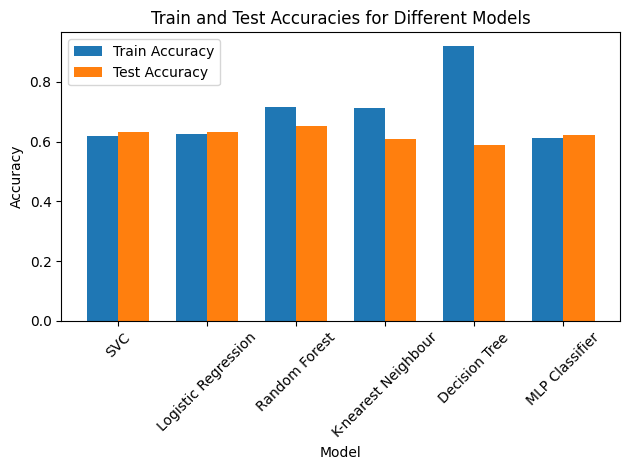

+---------------------+---------------------------+
| Model               |   Training Time (seconds) |
+=====================+===========================+
| SVC                 |                 4051.54   |
+---------------------+---------------------------+
| Logistic Regression |                    0.1272 |
+---------------------+---------------------------+
| Random Forest       |                    0.3211 |
+---------------------+---------------------------+
| K-nearest Neighbour |                    0.0119 |
+---------------------+---------------------------+
| Decision Tree       |                    0.0273 |
+---------------------+---------------------------+
| MLP Classifier      |                    0.3787 |
+---------------------+---------------------------+


In [32]:
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

models = ['SVC', 'Logistic Regression', 'Random Forest', 'K-nearest Neighbour', 'Decision Tree', 'MLP Classifier']
train_accuracy = [0.6184, 0.6256, 0.7150, 0.7124, 0.9198, 0.6131]
test_accuracy = [0.6328, 0.6315, 0.6538, 0.6092, 0.5896, 0.6233]
training_times = [4051.54, 0.1272, 0.3211, 0.0119, 0.0273, 0.3787]

# Plotting train and test accuracies
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
train_bar = ax.bar(x - width/2, train_accuracy, width, label='Train Accuracy')
test_bar = ax.bar(x + width/2, test_accuracy, width, label='Test Accuracy')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Train and Test Accuracies for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()

fig.tight_layout()
plt.show()

#print table data to summarize training time - due to high training times for SVM
table_data = []
for model, time in zip(models, training_times):
    table_data.append([model, time])

table_headers = ['Model', 'Training Time (seconds)']
table = tabulate(table_data, headers=table_headers, tablefmt='grid')

print(table)



# **Further Refinement to Decision Tree Model**

In [127]:
#Training Data & Adding Cuisine Cariable

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import pandas as pd

# Take a copy of the original data and create the new_data DataFrame
new_data = data.copy()
new_data = new_data[new_data['Aggregate_rating'] != 0]

# Extract the first word from the 'Cuisines' column
new_data['single_cuisines'] = new_data['Cuisines'].str.split().str[0].str.replace(',', '')

# Perform one-hot encoding on the 'single_cuisines' column
encoded_cuisines = pd.get_dummies(new_data['single_cuisines'], prefix='cuisine')

# Concatenate the original DataFrame with the encoded_cuisines DataFrame
new_data = pd.concat([new_data, encoded_cuisines], axis=1)
new_data.dropna(inplace=True)

# Define the features and target variables
X = new_data[['Price_range', 'Votes', 'Average Cost for two (USD)'] + encoded_cuisines.columns.tolist()]
y = new_data['Rating_text']

# Split the data into training and test sets with a 85:15 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=42)

# Create an instance of Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()

# Define the parameter grid for grid search
param_grid = {
    'max_depth': [5, 10, 20, 40],
    'min_samples_split': [10, 20, 80, 100],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

# Fit the grid search on the training data and measure the training time
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

# Create a grid search object
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Calculate and print the training and test scores using the best model
training_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate the precision
precision = precision_score(y_test, y_pred, average='weighted')

# Store the results in the dictionary
model_results = {
    'Decision Tree': {
        'Best Parameters': best_params,
        'Training Score': training_score,
        'Test Score': test_score,
        'Precision': precision,
        'Training Time': training_time
    }
}

# Print the results for the Decision Tree model
model = 'Decision Tree'
result = model_results[model]
print("Model:", model)
print("Best Parameters:", result['Best Parameters'])
print("Training Score:", result['Training Score'])
print("Test Score:", result['Test Score'])
print("Precision:", result['Precision'])
print("Training Time:", result['Training Time'])



Model: Decision Tree
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 10}
Training Score: 0.6955332725615314
Test Score: 0.6394339015760695
Precision: 0.6155564832884178
Training Time: 14.51120901107788


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Get Training Time for Best Model**

In [10]:
from sklearn.tree import DecisionTreeClassifier
import time

# Create an instance of Decision Tree Classifier with desired parameters
dt_classifier = DecisionTreeClassifier(criterion ='gini', max_depth =5, max_features = None, min_samples_leaf =5, min_samples_split =10)

# Start measuring training time
start_time = time.time()

# Fit the Decision Tree Classifier on the training data
dt_classifier.fit(X_train, y_train)

# Stop measuring training time and calculate elapsed time
end_time = time.time()
training_time = end_time - start_time

# Calculate the training score
training_score = dt_classifier.score(X_train, y_train)

# Calculate and print the training and test scores
print("Decision Tree Training score:", training_score)
print("Decision Tree Test score:", dt_classifier.score(X_test, y_test))
print("Decision Tree Training time:", training_time, "seconds")

Decision Tree Training score: 0.6521654311353882
Decision Tree Test score: 0.6419472247497725
Decision Tree Training time: 0.01502227783203125 seconds
